# Восстановление золота из руды

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

### Проверка коэффициента эффективности обогащения.

Проверим правильность расчёта эффективности обогащения (признак - rougher.output.recovery).

In [4]:
def recovery(C, F, T):
    """
    где:
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    """
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    
    return recovery

По формуле выше расчитаем коэффициент эффективности обогащения для данных из обучающей выборки.

In [5]:
comparison_table = pd.DataFrame()
comparison_table['rougher.output.recovery'] = train['rougher.output.recovery']
comparison_table['rougher.output.calc_recovery'] = recovery(
    train['rougher.output.concentrate_au'],
    train['rougher.input.feed_au'],
    train['rougher.output.tail_au']
)
comparison_table.head()

,rougher.output.recovery,rougher.output.calc_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Для вычисления среднего абсолютного отклонения (MAE) проверим данные на наличие пропусков.

In [6]:
comparison_table.isna().sum()

rougher.output.recovery         2573
rougher.output.calc_recovery    2573
dtype: int64

Заполним пропуски нулями:

In [7]:
comparison_table.fillna(0, inplace=True)

In [8]:
 mean_absolute_error(comparison_table['rougher.output.recovery'], comparison_table['rougher.output.calc_recovery'])

8.00350954615662e-15

#### Вывод.
Значение МАЕ крайне мало, поэтому можно считать, что значение коэффициента посчитано верно.

### Сравнение тестовой и обучающей выборок.

Перед обучением моделей необходимо убедиться, что в обучающей и тестовой выборках присутствуют одни и те же признаки.

In [9]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют параметры продукта и расчётные характеристики. Удалим из обучающей выборки все признаки, которых нет в тестовой.

In [10]:
train = train.drop(set(train.columns) - set(test.columns), axis=1)

### Предобработка данных

Перенесем значения столбца 'date' в индекс датасетов для дальнейшей индексации.

In [11]:
full = full.set_index('date')
train = train.set_index('date')
test = test.set_index('date')

Посмотрим на соотношение пропусков в данных

In [12]:
def report(df):
    report = df.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] * 100 / df.shape[0]).round(2)
    return display(report.sort_values(by = 'missing_values', ascending = False).head(10))

In [13]:
report(train)

,missing_values,% of total
rougher.input.floatbank11_xanthate,1904,11.29
primary_cleaner.input.sulfate,1307,7.75
primary_cleaner.input.depressant,1262,7.49
rougher.input.floatbank10_sulfate,1044,6.19
primary_cleaner.input.xanthate,985,5.84
rougher.input.floatbank11_sulfate,623,3.70
rougher.state.floatbank10_e_air,603,3.58
rougher.input.feed_rate,513,3.04
rougher.input.feed_size,417,2.47
secondary_cleaner.state.floatbank2_a_air,363,2.15


In [14]:
report(test)

,missing_values,% of total
rougher.input.floatbank11_xanthate,353,6.03
primary_cleaner.input.sulfate,302,5.16
primary_cleaner.input.depressant,284,4.85
rougher.input.floatbank10_sulfate,257,4.39
primary_cleaner.input.xanthate,166,2.83
rougher.input.floatbank10_xanthate,123,2.10
rougher.input.feed_sol,67,1.14
rougher.input.floatbank11_sulfate,55,0.94
rougher.input.feed_rate,40,0.68
secondary_cleaner.state.floatbank3_a_air,34,0.58


По условию значения соседних по времени параметры часто похожи. Заполним пропуски данным способом.

In [15]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

In [16]:
conc_ag = (
    full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
    .fillna(method='ffill')
    .set_axis(['rougher', 'primary_cleaner', 'final'], axis=1, inplace=False)    
)

conc_au = (
    full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
    .fillna(method='ffill')
    .set_axis(['rougher', 'primary_cleaner', 'final'], axis=1, inplace=False)    
)

conc_pb = (
    full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
    .fillna(method='ffill')
    .set_axis(['rougher', 'primary_cleaner', 'final'], axis=1, inplace=False)    
)

In [17]:
conc_ag.mean()

rougher            10.845609
primary_cleaner     7.666972
final               4.768013
dtype: float64

In [18]:
conc_au.mean()

rougher            17.831509
primary_cleaner    29.119967
final              39.891718
dtype: float64

In [19]:
conc_pb.mean()

rougher            6.886869
primary_cleaner    8.809217
final              9.071366
dtype: float64

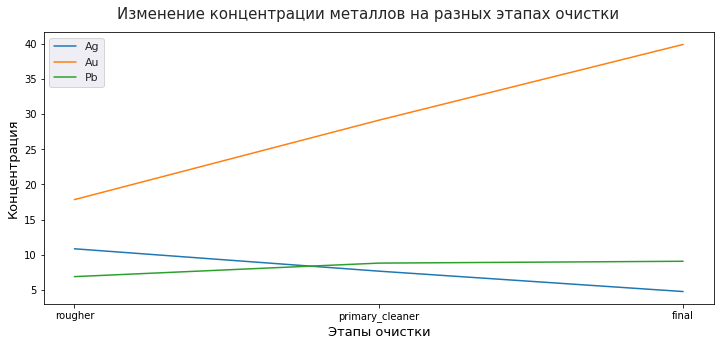

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12,5))

sns.set(style="darkgrid")
sns.lineplot(x=conc_ag.columns, y=conc_ag.mean(), label='Ag')
sns.lineplot(x=conc_au.columns, y=conc_au.mean(), label='Au')
sns.lineplot(x=conc_pb.columns, y=conc_pb.mean(), label='Pb')

plt.suptitle('Изменение концентрации металлов на разных этапах очистки',size=15, y=.95)
ax.set_xlabel('Этапы очистки', size=13)
ax.set_ylabel('Концентрация', size=13)
plt.gca().invert_xaxis()
plt.show()

Из полученных данных видно, что в процессе очистки концентрация серебра на каждом последующем этапе снижается, концентрации золота и свинца увеличиваются.

### Распределение размеров гранул сырья.

Сравним распределения размеров частиц на обучающей и тестовой выборках.

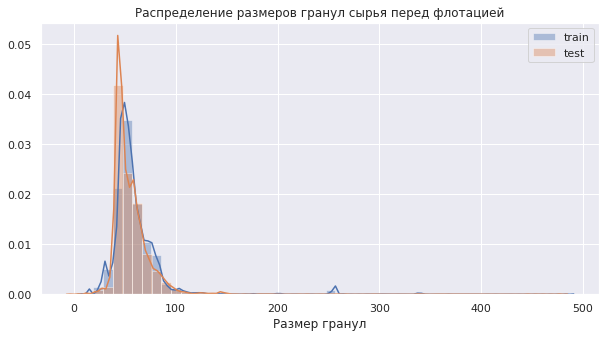

In [21]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
ax = sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
ax.set_title('Распределение размеров гранул сырья перед флотацией')
ax.set_xlabel('Размер гранул')
plt.legend()
plt.show()

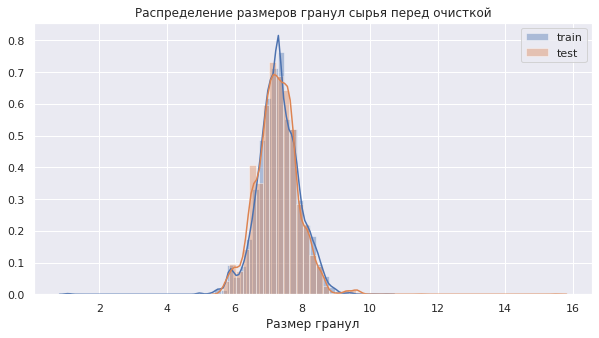

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.distplot(train['primary_cleaner.input.feed_size'].dropna(), label='train')
ax = sns.distplot(test['primary_cleaner.input.feed_size'].dropna(), label='test')
ax.set_title('Распределение размеров гранул сырья перед очисткой')
ax.set_xlabel('Размер гранул')
plt.legend()
plt.show()

Из графиков видно, что распределения практически идентичны.

### Суммарная концентрация всех веществ на разных стадиях.

Для того, чтобы исследовать суммарную концентрацию всех веществ на разных стадиях выделим из исходных данных столбцы с концентрациями. Заполним пропуски значениями из ближайших строк.

In [23]:
sum_conc = full[['rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.feed_ag',
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
    'rougher.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol',
    'final.output.concentrate_au']]

In [24]:
sum_conc = sum_conc.fillna(method='ffill')

Посчитаем суммарные концентрации на стадиях загрузки, после флотации и после очистки:

In [25]:
sum_conc['raw'] = sum_conc.iloc[:, :4].sum(axis=1)
sum_conc['rough'] = sum_conc.iloc[:, 4:8].sum(axis=1)
sum_conc['final'] = sum_conc.iloc[:, 8:12].sum(axis=1)

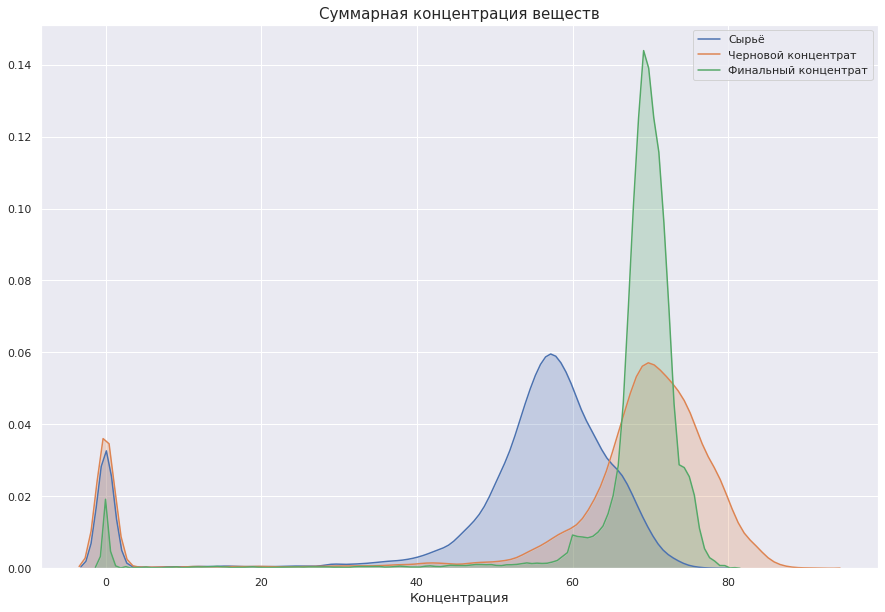

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(15,10))

sns.kdeplot(sum_conc['raw'], label='Сырьё', shade=True)
sns.kdeplot(sum_conc['rough'], label='Черновой концентрат', shade=True)
sns.kdeplot(sum_conc['final'], label='Финальный концентрат', shade=True)

ax.set_title('Суммарная концентрация веществ',size=15, y=1)
ax.set_xlabel('Концентрация', size=13)

plt.show()

Из графика видно, что имеются нулевые значения суммарных концентраций, что маловероятно. Данные значения лучше исключить из выборок перед построением моделей.

In [28]:
sum_conc_clean = sum_conc[(sum_conc['raw'] > 0) & (sum_conc['rough'] > 0) & (sum_conc['final'] > 0)]

Посчитаем, как много данных пришлось отбросить:

In [29]:
(len(sum_conc) - len(sum_conc_clean)) * 100 / len(sum_conc)

10.107413276985385

Оставим в выборках только строки с ненулевыми значениями суммарных концентраций.

In [30]:
train = train.query('index in @sum_conc_clean.index')
test = test.query('index in @sum_conc_clean.index')

## Модель

### sMAPE.

In [31]:
def smape(true, pred):
    
    smape = 1 / len(true) * sum(abs(true - pred) / ((abs(true) + abs(pred)) * 0.5)) * 100
    
    return smape

In [32]:
def smape_final(smape_rough, smape_final):
    
    smape_final = 0.25 * smape_rough + 0.75 * smape_final
    
    return smape_final

### Выбор лучшей модели.

Выделим признаки и целевые признаки:

In [33]:
X_train_rough = train[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size',
    'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]
y_train_rough = full.loc[train.index, 'rougher.output.recovery']

X_train_final = train
y_train_final = full.loc[train.index, 'final.output.recovery']

Применим масштабирование

In [34]:
scaler_rough = StandardScaler()
scaler_final = StandardScaler()

scaler_rough.fit(X_train_rough)
scaler_final.fit(X_train_final)
X_train_rough = scaler_rough.transform(X_train_rough)
X_train_final = scaler_final.transform(X_train_final)

#### Линейная регрессия.

In [35]:
model_lr = LinearRegression()

smape_lr_rough = cross_val_score(model_lr, X_train_rough, y_train_rough, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

smape_lr_final = cross_val_score(model_lr, X_train_final, y_train_final, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

In [36]:
print('Линейная регрессия:')
print(f'sMAPE после флотации: {smape_lr_rough:.2f} %')
print(f'sMAPE после очистки: {smape_lr_final:.2f} %')
print(f'Итоговое sMAPE: {smape_final(smape_lr_rough, smape_lr_final):.2f} %')

Линейная регрессия:
sMAPE после флотации: 8.32 %
sMAPE после очистки: 13.44 %
Итоговое sMAPE: 12.16 %


#### Дерево решений.

In [37]:
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=3)

smape_dtr_rough = cross_val_score(model_dtr, X_train_rough, y_train_rough, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

smape_dtr_final = cross_val_score(model_dtr, X_train_final, y_train_final, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

In [38]:
print('Дерево решений:')
print(f'sMAPE после флотации: {smape_dtr_rough:.2f} %')
print(f'sMAPE после очистки: {smape_dtr_final:.2f} %')
print(f'Итоговое sMAPE: {smape_final(smape_dtr_rough, smape_dtr_final):.2f} %')

Дерево решений:
sMAPE после флотации: 8.75 %
sMAPE после очистки: 10.69 %
Итоговое sMAPE: 10.20 %


#### Случайный лес.

In [ ]:
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=5)

smape_rfr_rough = cross_val_score(model_rfr, X_train_rough, y_train_rough, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

smape_rfr_final = cross_val_score(model_rfr, X_train_final, y_train_final, 
                             scoring = make_scorer(smape),
                             cv = 5).mean()

In [ ]:
print('Дерево решений:')
print(f'sMAPE после флотации: {smape_rfr_rough:.2f} %')
print(f'sMAPE после очистки: {smape_rfr_final:.2f} %')
print(f'Итоговое sMAPE: {smape_final(smape_rfr_rough, smape_rfr_final):.2f} %')

Наименьшее итоговое значение sMAPE показала модель случайного леса. Выберем её для проверки на тестовой выборке.

#### Проверка качества на тестовой выборке.

In [ ]:
X_test_rough = test[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size',
    'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]
y_test_rough = full.loc[test.index, 'rougher.output.recovery']

X_test_final = test
y_test_final = full.loc[test.index, 'final.output.recovery']

In [ ]:
X_test_rough = scaler_rough.transform(X_test_rough)
X_test_final = scaler_final.transform(X_test_final)

In [ ]:
model_rfr_rough = model_rfr.fit(X_train_rough, y_train_rough)
rough_predict = model_rfr_rough.predict(X_test_rough)

In [ ]:
model_rfr_final = model_rfr.fit(X_train_final, y_train_final)
final_predict = model_rfr_final.predict(X_test_final)

In [ ]:
print(f'sMAPE после флотации: {smape(y_test_rough, rough_predict):.2f} %')
print(f'sMAPE после очистки:  {smape(y_test_final, final_predict):.2f} %')
print(f'Итоговое sMAPE: {smape_final(smape(y_test_rough, rough_predict), smape(y_test_final, final_predict)):.2f} %')

#### Проверка на DummyRegressor.

In [ ]:
from sklearn.dummy import DummyRegressor

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")

In [ ]:
dummy_rough = dummy_regr.fit(X_train_rough, y_train_rough)
preds_rough = dummy_rough.predict(X_test_rough)

In [ ]:
dummy_final = dummy_regr.fit(X_train_final, y_train_final)
preds_final = dummy_final.predict(X_test_final)

In [ ]:
print(f'sMAPE после флотации: {smape(y_test_rough, preds_rough):.2f} %')
print(f'sMAPE после очистки:  {smape(y_test_final, preds_final):.2f} %')
print(f'Итоговое sMAPE: {smape_final(smape(y_test_rough, preds_rough), smape(y_test_final, preds_final)):.2f} %')

## Вывод.

В результате исследования были проверены три модели. Метрика качества sMAPE (симметричное среднее абсолютное процентное отклонение) на тестовой выборке на модели случайного леса - 7.7 %. Данное значение ниже, чем на dummy-модели.